In [1]:
using JLD2
using Printf
using CairoMakie
using FourierFlows
using LinearAlgebra: ldiv!, mul!

include("../../utils/IFMAB3.jl")
include("../../swqg/SWQG.jl")
using .SWQG: streamfunctionfrompv!

In [2]:
data_directory = "/scratch/nad9961/swqg/53531742/6/"

"/scratch/nad9961/swqg/53531742/6/"

In [32]:
function read_parameters(directory)
    file = jldopen(@sprintf("%s/packets.%06d.jld2", directory, 0))
    f0 = file["params/f0"]
    Cg = file["params/Cg"]
    close(file)
    return f0, Cg
end

function count_qgsw_snapshots(directory)
    num_snapshots = 0
    filename_func(idx) = @sprintf("%s/qgsw.%06d.jld2", directory, idx)
    num_files = sum([1 for file in readdir(directory) if occursin("qgsw.", file)])-1
    file_idx = 1
    for j=0:num_files
        file = jldopen(filename_func(j))
        num_snapshots += length(keys(file["snapshots/t"]))
        close(file)
    end
    return num_snapshots
end

function count_snapshots(directory)
    num_snapshots = 0
    filename_func(idx) = @sprintf("%s/packets.%06d.jld2", directory, idx)
    num_files = sum([1 for file in readdir(directory) if occursin("packets.", file)])-1
    file_idx = 1
    for j=0:num_files
        file = jldopen(filename_func(j))
        num_snapshots += length(keys(file["p/t"]))
        close(file)
    end
    return num_snapshots
end

function load_snapshot(directory, snap_idx)
    filename_func(idx) = @sprintf("%s/packets.%06d.jld2", directory, idx)
    num_files = sum([1 for file in readdir(directory) if occursin("packets.", file)])-1
    file_idx = 0
    num_snapshots = 0
    file = nothing
    file_idx = snap_idx
    for j=0:num_files
        file = jldopen(filename_func(j))
        num_snapshots += length(keys(file["p/t"]))
        if snap_idx <= num_snapshots
            break
        end
        file_idx -= length(keys(file["p/t"]))
        close(file)
    end
    snapshot = keys(file["p/t"])[file_idx]
    t =  file["p/t/" * snapshot]
    x =  file["p/x/" * snapshot]
    k =  file["p/k/" * snapshot]
    u =  file["p/u/" * snapshot]
    close(file)
    return (t, x, k, u)
end

function count_qgsw_snapshots(directory)
    num_snapshots = 0
    filename_func(idx) = @sprintf("%s/qgsw.%06d.jld2", directory, idx)
    num_files = sum([1 for file in readdir(directory) if occursin("qgsw.", file)])-1
    file_idx = 1
    for j=0:num_files
        file = jldopen(filename_func(j))
        num_snapshots += length(keys(file["snapshots/t"]))
        close(file)
    end
    return num_snapshots
end

function load_qgsw_snapshot(directory, snap_idx)
    filename_func(idx) = @sprintf("%s/qgsw.%06d.jld2", directory, idx)
    num_files = sum([1 for file in readdir(directory) if occursin("qgsw.", file)])-1
    num_snapshots = 0
    file = nothing
    file_idx = snap_idx
    for j=0:num_files
        file = jldopen(filename_func(j))
        num_snapshots += length(keys(file["snapshots/t"]))
        if snap_idx <= num_snapshots
            break
        end
        file_idx -= length(keys(file["snapshots/t"]))
        close(file)
    end
    grid = TwoDGrid(; nx=file["grid/nx"], Lx=file["grid/Lx"])
    Kd2 = file["params/Kd2"]
    key = keys(file["snapshots/t"])[file_idx]
    t = file["snapshots/t/" * key]
    qh = file["snapshots/sol/" * key]
    ψh = -qh ./ (grid.Krsq .+ Kd2)
    uh = -1im * grid.l .* ψh
    vh =  1im * grid.kr .* ψh
    q = irfft(qh, grid.nx)
    ψ = irfft(ψh, grid.nx)
    u = irfft(uh, grid.nx)
    v = irfft(vh, grid.nx)

    close(file)
    return t, q, ψ, u, v, Kd2, grid
end

load_qgsw_snapshot (generic function with 2 methods)

In [137]:
function mean(data)
    return sum(data) / length(data)
end

function variance(data)
    return sum((data .- mean(data)).^2) / length(data)
end

function std(data)
    return sqrt.(variance(data))
end

std (generic function with 1 method)

In [4]:
function compute_ω(k, f, Cg)
    return sqrt.(f^2 .+ Cg^2*(k[:,1].^2 + k[:,2].^2))
end

function compute_doppler_shift(k, u)
    return @. k[:,1] * u[:,1] + k[:,2] * u[:,2]
end

function compute_Ω(k, u, f, Cg)
    return compute_ω(k, f, Cg) + compute_doppler_shift(k, u)
end

compute_Ω (generic function with 1 method)

In [164]:
Nsnapshots = count_snapshots(data_directory)
Nqgsw_snapshots = count_qgsw_snapshots(data_directory)
snap_idx = 2
packet_idx = 6
(t_qgsw, q, ψ, u, v, Kd2, grid) = load_qgsw_snapshot(data_directory, snap_idx)
(t, x, k, pu) = load_snapshot(data_directory, packet_idx)
f, sqrtgH = read_parameters(data_directory)

println(t_qgsw)
println(t)

213.35895
213.35895


In [165]:
ω = compute_ω(k, f, sqrtgH)
Uk = compute_doppler_shift(k, pu);
mean_Uk = mean(Uk)
std_Uk = std(Uk)

rms_U = sqrt.(sum(u.^2 + v.^2) / size(u, 1) / size(u, 2))
packet_rms_U = sqrt.(sum(pu[:,1].^2 + pu[:,2].^2) / size(pu, 1))
rms_Cg = sqrt.(sum((sqrtgH^2 * k ./ ω).^2) / size(k, 1))
println("RMS U: ", rms_U)
println("packet RMS U: ", packet_rms_U)
println("√gH: ", sqrtgH)
println("RMS Cg: ", rms_Cg)
println(@sprintf("Background Froude: %0.3f", rms_U / sqrtgH))
println(@sprintf("Packet Froude: %0.3f", packet_rms_U / rms_Cg))

RMS U: 0.13366322267827058
packet RMS U: 0.18012848
√gH: 0.5
RMS Cg: 0.37566944654947154
Background Froude: 0.267
Packet Froude: 0.479


In [166]:
sqrt.(sum(pu[:,1].^2 + pu[:,2].^2) / size(pu, 1))

0.18012848f0

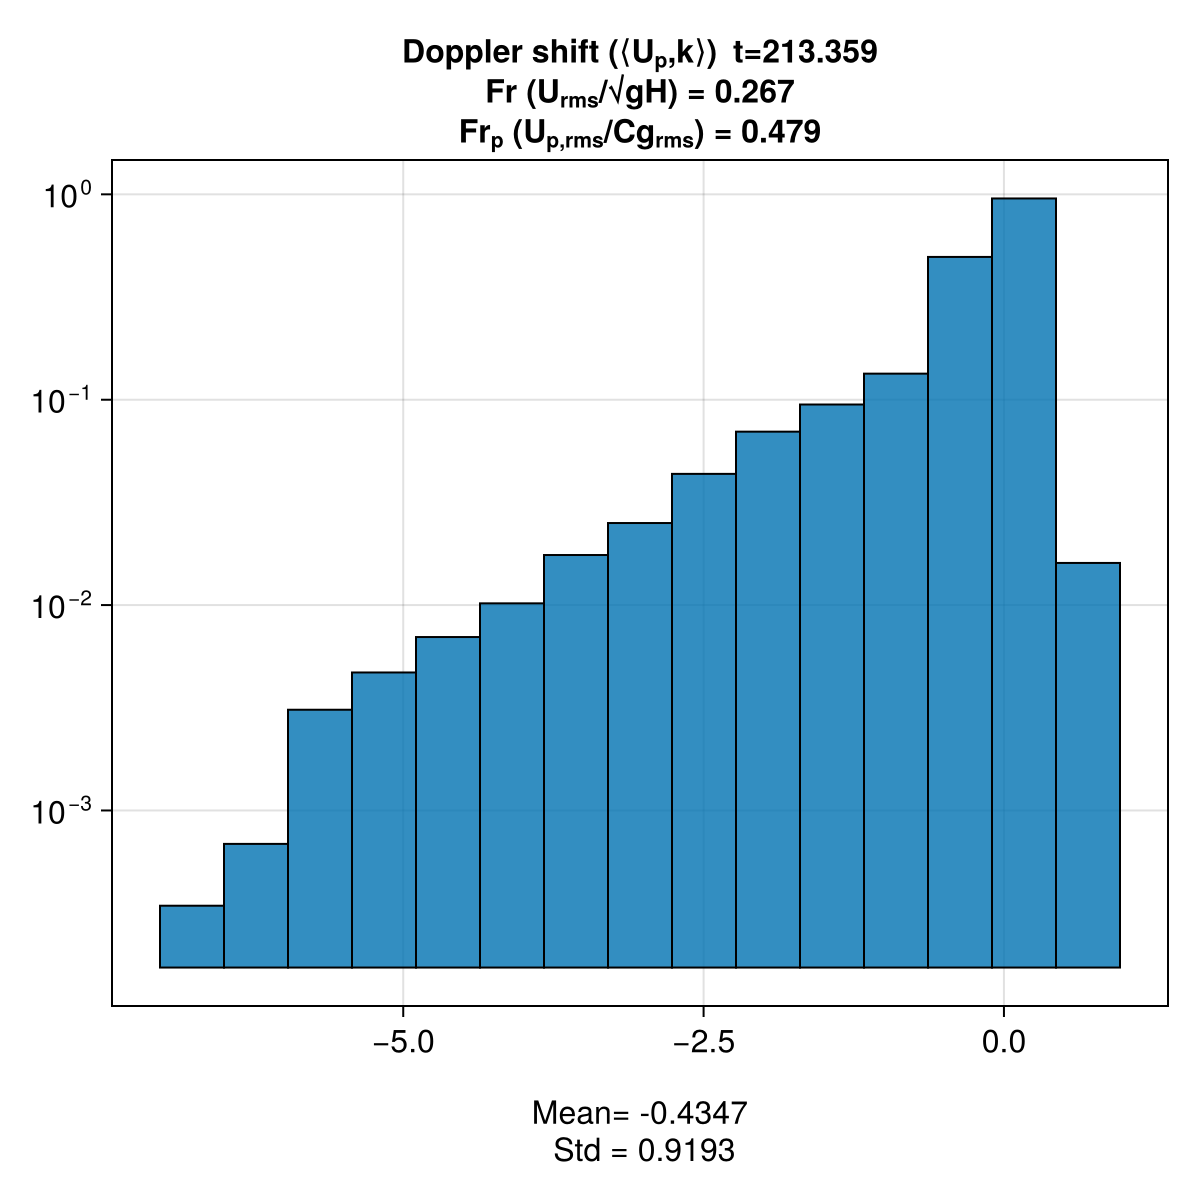

In [167]:
doppler_bias_fig = Figure(size=(600, 600), fontsize=16)
ax = Axis(doppler_bias_fig[1,1], title=rich("Doppler shift (⟨U",subscript("p"),",k⟩)", @sprintf("\tt=%0.3f\n", t_qgsw), 
         "Fr (U", subscript("rms"), "/√gH) = ", @sprintf("%0.3f\n", rms_U / sqrtgH),
         "Fr", subscript("p"), " (U", subscript("p,rms"), "/Cg", subscript("rms"), ") = ", @sprintf("%0.3f", packet_rms_U / rms_Cg)),
        yscale=log10)

hist!(ax, Uk, normalization = :pdf, strokewidth = 1, strokecolor = :black)
Label(doppler_bias_fig[2,1], @sprintf("Mean= %0.4f\n Std = %0.4f", mean_Uk, std_Uk))
colsize!(doppler_bias_fig.layout, 1, Relative(1))
resize_to_layout!(doppler_bias_fig)
save(@sprintf("doppler_shift_bias_idx=%d.png", snap_idx), doppler_bias_fig)
doppler_bias_fig

In [153]:
doppler_shift1 = k[:,1] .* pu[:,1]
doppler_shift2 = k[:,2] .* pu[:,2]
println(sum(doppler_shift1) / length(doppler_shift1))
println(sum(doppler_shift2) / length(doppler_shift1))

-0.16754748
-0.26717973
